In [1]:
import os
import cv2
import math
import  time
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import concurrent.futures
import matplotlib.pyplot as plt
from IPython.display import display as ds
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps, ImageCms
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

# from pymatting.alpha.estimate_alpha_cf import estimate_alpha_cf
# from pymatting.foreground.estimate_foreground_ml import estimate_foreground_ml

%matplotlib inline

In [2]:
cv2.useOptimized()

True

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# 載入 Unet Model 去背使用

# 載入 Object Detection Model 使用

In [4]:
# def detect(input_tensor):
#     return detection_model(input_tensor)
#detection_model = tf.saved_model.load('detection_model').signatures['detection']

In [5]:
def dice_coef(y_true, y_pred):
    '''
    Metric
    '''
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    '''
    Loss function
    '''
    loss = 1 - dice_coef(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    '''
    Mixed crossentropy and dice loss.
    '''
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def phi(img, contrast): # contrast - 減少對比度/+ 增加對比度     
    # 調整對比度
    brightness = 0
    B = brightness / 255.0
    c = contrast / 255.0 
    k = math.tan((45 + 44 * c) / 180 * math.pi)                
    img = (img - 127.5 * (1 - B)) * k + 127.5 * (1 + B)
    # 所有值必須介於 0~255 之間，超過255 = 255，小於 0 = 0
    img = np.clip(img, 0, 255)    
    return img

def cv2_to_plt(img_np):
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    img_np = img_np/255
    return img_np

def plt_to_cv2(img_np):
    return cv2.cvtColor((img_np*255).astype("uint8"), cv2.COLOR_RGB2BGR)

def stored(path, store = r"C:\Users\sky66\Desktop\predict"):
    name = path.split("\\")[-1].split(".")[0]
    a,b,c = pred(path)
    cv2.imwrite(store+"\\"+name+"_image.jpg", b)
    cv2.imwrite(store+"\\"+name+"_mask.jpg", a)   
    cv2.imwrite(store+"\\"+name+"_predict.jpg", c) 
    
def Unet_predict(img_np):
    # format cv2 GRAY
    
    # Resize to predict
    width = img_np.shape[1]
    height = img_np.shape[0]
    img_np = cv2.resize(img_np, (256,256))
    
    # use to predict
    img_np = img_np/255
    img_np = np.reshape(img_np,(256,256,3))
    img_np = np.expand_dims(img_np, 0)
    
    # predict
    pred_mask = UNet.predict(img_np)
    pred_mask = pred_mask[0]
    
    # process image
    # mask is GRAYSCALE
    # Resize to origin size
    pred_mask = pred_mask*255
    pred_mask = cv2.resize(pred_mask, (width,height))
    pred_mask = pred_mask/255
    pred_mask = np.reshape(pred_mask,(height,width,1))
    
    return pred_mask       

def img_to_tensor(img_np):
    img_tf = tf.convert_to_tensor(img_np, dtype=tf.float32 )
    img_tf = tf.expand_dims(img_tf, axis=0) 
    return img_tf 

def img_proccess(img):
    img = Image.open(img)
    
    detection_img = img.resize((640,640))
    detection_img = np.array(detection_img)
    
    img = np.array(img)
    origin_img = np.zeros(img.shape)
    
    np.copyto(origin_img ,img)
    
    detection_img = img_to_tensor(detection_img)
    
    return {'origin_img_np':origin_img , 'detection_img_tensor':detection_img}

def Get_Dectection_Model_Not_Export(pipeline_config, checkpoint_path):
    tf.keras.backend.clear_session()
    
    configs = config_util.get_configs_from_pipeline_file(pipeline_config)
    model_config = configs['model']
    # model_config.ssd.freeze_batchnorm = True
    detection_model = model_builder.build(
          model_config=model_config, is_training=True)
    
    fake_box_predictor = tf.compat.v2.train.Checkpoint(
        _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
        _prediction_heads=detection_model._box_predictor._prediction_heads,
        _box_prediction_head=detection_model._box_predictor._box_prediction_head,
        )
    
    fake_model = tf.compat.v2.train.Checkpoint(
              _feature_extractor=detection_model._feature_extractor,
              _box_predictor=fake_box_predictor)
    ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
    ckpt_manager = tf.train.CheckpointManager(ckpt, directory=checkpoint_path, max_to_keep=5)
    print(ckpt_manager.latest_checkpoint)
    ckpt.restore(ckpt_manager.latest_checkpoint)
    # ckpt.restore(checkpoint_path).expect_partial()
    
    # Run model through a dummy image so that variables are created
    image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
    prediction_dict = detection_model.predict(image, shapes)
    _ = detection_model.postprocess(prediction_dict, shapes)
    print('Weights restored!')
    return detection_model

def draw_bounding_box_on_image(image,
                                 ymin,
                                 xmin,
                                 ymax,
                                 xmax,
                                 color = list(ImageColor.colormap.values())[0],
                                 font = ImageFont.load_default(),
                                 thickness=4,
                                 display_str_list=()):
    # image format RGB np.array (0~255)
    """Adds a bounding box to an image."""
    image = Image.fromarray(np.uint8(image)).convert("RGB")
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)
    
    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin
    return image  
  
def draw_boxes(
         image, 
         class_names, 
         boxes,
         scores,
         score_limit,
         min_box,
         max_box,
         box_process=None,
         draw_mask = True,
         draw_box = True,
         min_limit_score = 0):
    # image format RGB np.array (0~255)
    now_image_np = np.zeros((image.shape))
    origin_image_np = np.zeros((image.shape))
    now_mask_np = np.zeros((image.shape))
    np.copyto(now_image_np , image)
    np.copyto(origin_image_np , image)
    w, h = origin_image_np.shape[1], origin_image_np.shape[0]
    
    class_names = class_names.tolist()
    boxes = boxes.tolist()
    scores = scores.tolist()
    
    new_class_names = []
    new_boxes = []
    new_scores = []
    
    if max_box>len(boxes):
        max_box = len(boxes)
    
    for e in range(max_box):
        big = 0
        for e in range(len(boxes)):
            if scores[e]>scores[big]:
                big = e
        new_class_names.append(class_names.pop(big))
        new_boxes.append(boxes.pop(big))
        new_scores.append(scores.pop(big))     
        
    class_names = new_class_names
    boxes = new_boxes
    scores = new_scores
    flag = False
    def judge(i):
        if i+1 <= min_box:
            if float(scores[i])<min_limit_score:
                return False
            else:
                return True
        else:
            return float(scores[i])>score_limit
    if draw_mask:
        for i in range(0,len(boxes)):
            if(judge(i)):
                flag = True
                box , score , class_name = boxes[i] , scores[i] , class_names[i]
                ymin, xmin, ymax, xmax = box
                ymin, xmin, ymax, xmax = [int(t) for t in [ymin*h, xmin*w, ymax*h, xmax*w]]
                if box_process!=None:
                    ymin, xmin, ymax, xmax = box_process(ymin, xmin, ymax, xmax, h, w)
                predict_img = origin_image_np[ymin:ymax, xmin:xmax][:]
                predict_img = cv2.cvtColor(predict_img.astype("uint8"), cv2.COLOR_RGB2BGR)
                pred_mask = Unet_predict(predict_img)
                now_mask_np[ymin:ymax, xmin:xmax] = now_mask_np[ymin:ymax, xmin:xmax]+pred_mask
            else:
                break
                
        now_mask_np = np.clip(now_mask_np, 0, 1) 
        if flag:
            now_image_np = now_image_np*now_mask_np
        now_image_np = now_image_np.astype("uint8")
    
    if draw_box:
        for i in range(0,len(boxes)):
            if(judge(i)):
                box , score , class_name = boxes[i] , scores[i] , class_names[i]
                # print(box)
                class_name = "Person"
                colors = list(ImageColor.colormap.values())
                      
                font = ImageFont.load_default()
                display_str = (class_name+":"+str(score))
                color = colors[hash(class_name) % len(colors)]
                
                image_pil = Image.fromarray(np.uint8(now_image_np)).convert("RGB")
                
                image_pil = draw_bounding_box_on_image(
                    image_pil,
                    *box,
                    list(ImageColor.colormap.values())[0],
                    ImageFont.load_default(),
                    display_str_list=["Person"+":"+str(score)])
                np.copyto(now_image_np, np.array(image_pil) )
            else:
                break
    now_image_np = now_image_np.astype("uint8")
    return origin_image_np, now_mask_np*255, now_image_np

def view(path, 
         min_predict_score, 
         min_box, 
         max_view_box, 
         img_process, 
         box_process=None, 
         draw_mask=True, 
         draw_box=True, 
         display=True,
         min_limit_score = 0):
    test_img = path
    print(path)
    predict_img = cv2.imread(test_img)
    return view_v1(predict_img,
                   min_predict_score,
                   min_box,
                   max_view_box,
                   img_process,
                   box_process,
                   draw_mask,
                   draw_box,
                   display,
                   min_limit_score)

def view_v1(predict_img, 
            min_predict_score, 
            min_box, max_view_box, 
            img_process, 
            box_process=None, 
            draw_mask=True, 
            draw_box=True, 
            display=True, 
            min_limit_score=0):
    tmp = [predict_img, min_predict_score, min_box, max_view_box, img_process, box_process, draw_mask, draw_box, min_limit_score]
    detection_result, origin_image_np, now_mask_np, predict_result = prediction(*tmp)
    # view
    if display:
        fig, ax = plt.subplots(1, 3, figsize=(80,80))
        ax[0].imshow(origin_image_np)
        ax[0].axis('off')
        ax[1].imshow(now_mask_np , cmap='gray')
        ax[1].axis('off')
        # ax[2].imshow(pred_img*np.where(pred_mask>0.1, 1, 0))
        ax[2].imshow(predict_result)
        ax[2].axis('off')
        plt.show() 
    return origin_image_np, now_mask_np, predict_result

def prediction(predict_img, min_predict_score, min_box, max_view_box, img_process, box_process=None, draw_mask=True, draw_box=True, min_limit_score=0):
    origin_img = predict_img.copy()
    origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
    predict_img = img_process(predict_img)
    detection_result = detect(predict_img)
    detection_result = [detection_result['detection_classes'][0].numpy(), 
                        detection_result['detection_boxes'][0].numpy(), 
                        detection_result["detection_scores"][0].numpy()]
    result = draw_boxes(
                         origin_img,
                         *detection_result,
                         min_predict_score,
                         min_box,
                         max_view_box,
                         box_process,
                         draw_mask,
                         draw_box,
                         min_limit_score = min_limit_score)
    origin_image_np, now_mask_np, predict_result = [e.astype("uint8") for e in result] 
    return detection_result, origin_image_np, now_mask_np, predict_result

In [6]:
pipeline_config = r"C:\Users\sky66\Downloads\models\research\ckpt\pipeline.config"
checkpoint_path = r"C:\Users\sky66\Downloads\models\research\ckpt"
detection_model = Get_Dectection_Model_Not_Export(pipeline_config, checkpoint_path)

@tf.function(input_signature=[tf.TensorSpec(shape=[None,640,640,3], dtype=tf.float32)])
def detect(input_tensor):
    # Note that the first frame will trigger tracing of the tf.function, which will
    # take some time, after which inference should be fast. 
    """Run detection on an input image.
    
    Args:
      input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
        Note that height and width can be anything since the image will be
        immediately resized according to the needs of the model within this
        function.
    
    Returns:
      A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
        and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

C:\Users\sky66\Downloads\models\research\ckpt\ckpt-1
Weights restored!


In [7]:
modelPath = r'C:\Users\sky66\Desktop\my_model'
UNet = tf.keras.models.load_model(modelPath, custom_objects={"dice_coef":dice_coef, "dice_loss":dice_loss, "bce_dice_loss":bce_dice_loss})

In [8]:
def img_process(predict_img):
    #predict_img = 255-predict_img  # 黑白顛倒
    predict_img = phi(predict_img, 100).astype("uint8") # - 減少對比度/+ 增加對比度 
    predict_img = cv2.resize(predict_img, (640,640))    
    predict_img = cv2.cvtColor(predict_img, cv2.COLOR_BGR2RGB)
    predict_img = tf.expand_dims(tf.convert_to_tensor(predict_img, dtype=tf.float32), axis=0)    
    return predict_img
def box_process(ymin, xmin, ymax, xmax, height, width):
    # cy = round(height*0.03)
    # ymin = ymin-cy if ymin-cy>=0 else ymin
    # print(ymin, xmin, ymax, xmax)
    return ymin, xmin, ymax, xmax

aa.png
Instructions for updating:
Use fn_output_signature instead


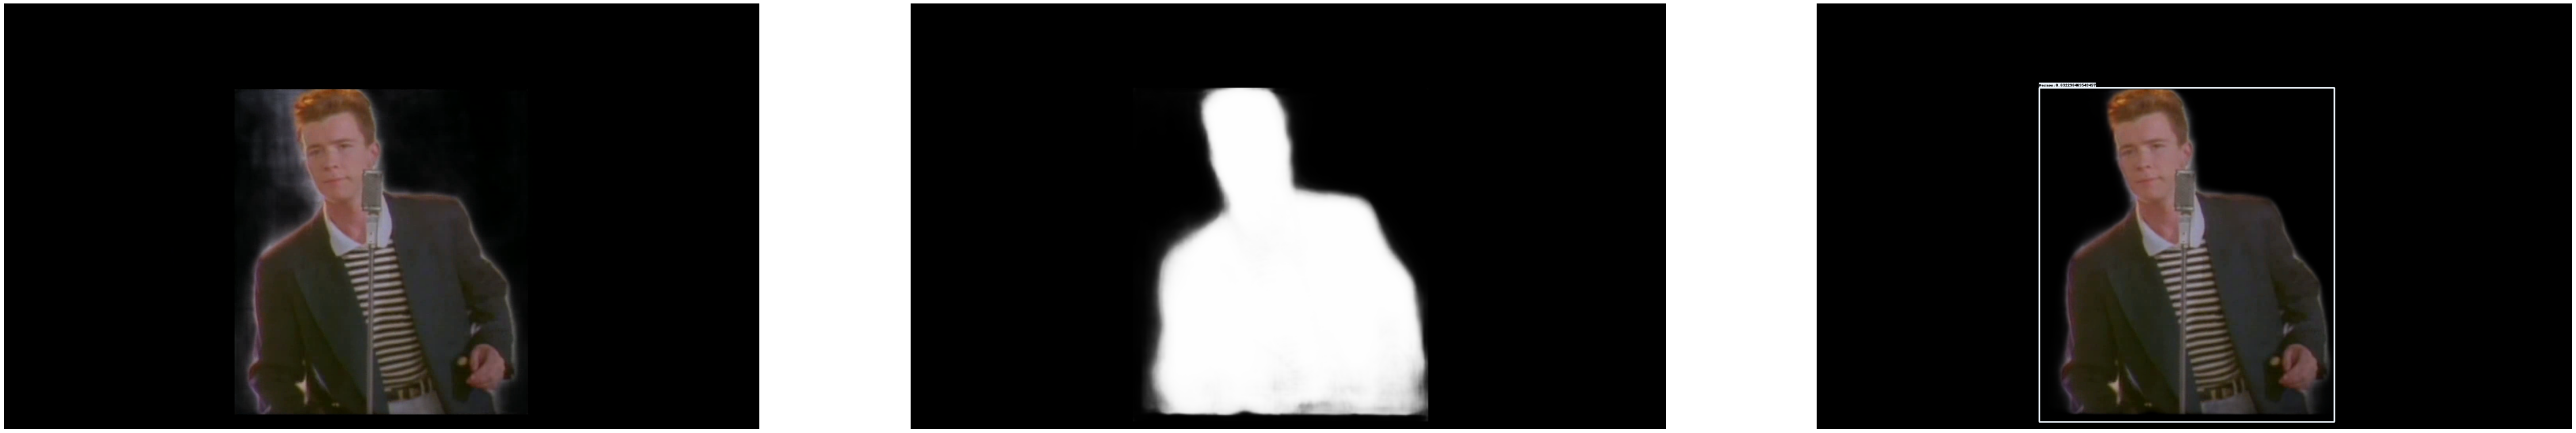

In [9]:
p = r"aa.png"
result = view(p, 0.5, 1, 3, img_process, box_process, min_limit_score=0.25)

In [ ]:
# plt.imshow(result[0]*(result[1]/255)/255)

In [ ]:
path = r"C:\Users\sky66\Desktop\Model\predict"+"\\"

for i in os.listdir(path):
    if i.split(".")[0].split("_")[-1] != "image":
        continue
    f = path+i
    view(f, 0.3, 1, 3, img_process, box_process, draw_box=True)
    input()
print("Finish")    

# 取得 Mask 及 BBox

In [12]:
score = 0.5
min_box = 1
max_box = 3
min_limit_score = 0.25

In [13]:
path = r"C:\Users\sky66\Downloads\Rick_Astley_Never_Gonna Give_You_Up Official_Music _Video_720p_v0.mp4"

cap = cv2.VideoCapture(path)
width = cap.get(3)
height = cap.get(4)
fps = cap.get(5)
frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

i = 0
try:
    with tqdm(total=frames, ncols=100, ascii=' >=') as pbar:
        while cap.isOpened():
            #print(cap.isOpened())
            ret, frame = cap.read()
            if not ret:
                break
                
            target = r"C:\Users\sky66\Downloads\rick roll\%d.jpg"%i
            bbox = r"C:\Users\sky66\Downloads\rick roll\%d.pkl"%i
            
            result = prediction(frame, score, min_box, max_box, img_process, box_process, draw_mask=True, draw_box=False, min_limit_score=min_limit_score)
            
            with open(bbox, "wb") as f:
                pickle.dump(result[0], f)
            
            result1 = cv2.resize(result[2], (256,256))
            cv2.imwrite(target, result1)
            
            i += 1
            #  pbar.set_postfix_str("{}%".format(int(i*100/frames)))
            pbar.update(1)
            
            if cv2.waitKey(1) == ord('q'):
                break
except:
    cv2.destroyAllWindows()  
    
# Release everything if job is finished
cap.release()
cv2.destroyAllWindows()

100%|===========================================================| 5301/5301 [32:42<00:00,  2.70it/s]


In [14]:
# Release everything if job is finished
pbar.close()
cap.release()
cv2.destroyAllWindows()

In [15]:
# frame = frame.astype("float32")
# target = r"C:\Users\sky66\Downloads\rick roll\%d.jpg"%15
# mask = cv2.resize(cv2.imread(target), (int(width),int(height)))
# mask = mask/255
# new_frame = np.clip(frame*mask, 0, 255).astype("uint8")
# plt.imshow(new_frame)

In [16]:
# plt.imshow(mask*255)

In [17]:
# plt.imshow(np.where(mask>0.5,1,mask))

In [18]:
# 做第一次..做第二次 或 做完加一次

In [19]:
def frame_mask(frame, e, i):
    target = r"C:\Users\sky66\Downloads\rick roll\%d.jpg"%i
    frame = frame.astype("float32")
    mask = cv2.resize(cv2.imread(target), (int(width),int(height))).astype("float32")
    mask = mask/255
    mask = np.where(mask>0.5, 1, mask)
    mask = np.where(mask<0.5, 0, mask)
    rmask = 1-mask
    new_frame = np.clip(frame*mask+background*rmask, 0, 255).astype("uint8")
    frames1[e] = new_frame
def bbox_get(e, i):
    bbox = r"C:\Users\sky66\Downloads\rick roll\%d.pkl"%i
    with open(bbox, "rb") as f:
        box = pickle.load(f)
    bboxes[e] = box
def process_(i):
    frames0[i] = draw_boxes(frames1[i], *bboxes[i], score, min_box, max_box, box_process, False, True, min_limit_score)[2]

In [20]:
path = r"C:\Users\sky66\Downloads\Rick_Astley_Never_Gonna Give_You_Up Official_Music _Video_720p_v0.mp4"
output1 = r"C:\Users\sky66\Downloads\Rick_Astley_Never_Gonna Give_You_Up Official_Music _Video_720p_b01.mp4"
output2 = r"C:\Users\sky66\Downloads\Rick_Astley_Never_Gonna Give_You_Up Official_Music _Video_720p_b02.mp4"
background = cv2.imread(r"C:\Users\sky66\Desktop\background.png").astype("float32")
cap = cv2.VideoCapture(path)
width = cap.get(3)
height = cap.get(4)
fps = cap.get(5)
frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out1 = cv2.VideoWriter(output1, fourcc, fps, (int(width),  int(height)))
#out2 = cv2.VideoWriter(output2, fourcc, fps, (int(width),  int(height)))

Max = 30
i = 0
frame, frames0, frames1, bboxes = [list(range(Max)) for _ in range(4)]
times = frames//Max
t = 0

In [21]:
pbar = tqdm(total = frames, ncols = 100, ascii=' >=')

try:
    while t<times:
        t += 1
        
        for e in range(Max):
            ret, frame[e] = cap.read()
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=Max) as executor:
            for e in range(Max):
                executor.submit(frame_mask, frame[e], e, i) 
                executor.submit(bbox_get, e, i)
                i += 1
        
        #with concurrent.futures.ThreadPoolExecutor(max_workers=Max) as executor:
        #    for e in range(Max):
        #        executor.submit(process_, e)
        
        for e in range(Max):
            #out2.write(frames0[e])
            out1.write(frames1[e])
        
        pbar.update(Max)
        #  pbar.set_postfix_str("{}%".format(int(i*100/frames)))
        
        if cv2.waitKey(1) == ord('q'): break
except Exception as e:
    pass 
    
# Release everything if job is finished
Max = frames%Max

for e in range(Max):
    ret, frame[e] = cap.read()

with concurrent.futures.ThreadPoolExecutor(max_workers=Max) as executor:
    for e in range(Max):
        executor.submit(frame_mask, frame[e], e, i) 
        executor.submit(bbox_get, e, i)
        i += 1
#with concurrent.futures.ThreadPoolExecutor(max_workers=Max) as executor:
#    for e in range(Max):
#        executor.submit(process_, e)

for e in range(Max):
    #out2.write(frames0[e])
    out1.write(frames1[e])

pbar.update(Max)
pbar.close()
cap.release()
out1.release()
#out2.release()
cv2.destroyAllWindows()

100%|===========================================================| 5301/5301 [08:56<00:00,  9.89it/s]


In [ ]:
pbar.close()
cap.release()
out1.release()
#out2.release()
cv2.destroyAllWindows()

# 現場取得 Mask 及 BBox，用黑色背景(不處理)進行去背

In [ ]:
def v1_img_process(predict_img):
    #predict_img = 255-predict_img  # 黑白顛到
    #predict_img = phi(predict_img, 100) # - 減少對比度/+ 增加對比度
    predict_img = cv2.resize(predict_img, (640,640))
    predict_img = cv2.cvtColor(predict_img, cv2.COLOR_BGR2GRAY)
    predict_img = cv2.cvtColor(predict_img, cv2.COLOR_GRAY2RGB)
    predict_img = tf.expand_dims(tf.convert_to_tensor(predict_img, dtype=tf.float32), axis=0)    
    return predict_img
def v1_box_process(ymin, xmin, ymax, xmax, height, width):
    # cy = round(height*0.03)
    # ymin = ymin-cy if ymin-cy>=0 else ymin
    # print(ymin, xmin, ymax, xmax)
    return ymin, xmin, ymax, xmax

path = r"C:\Users\sky66\Downloads\Rick_Astley_Never_Gonna Give_You_Up Official_Music _Video_720p_v0.mp4"
output1 = r"C:\Users\sky66\Downloads\Rick_Astley_Never_Gonna Give_You_Up Official_Music _Video_720p_01.mp4"
output2 = r"C:\Users\sky66\Downloads\Rick_Astley_Never_Gonna Give_You_Up Official_Music _Video_720p_02.mp4"

cap = cv2.VideoCapture(path)
width = cap.get(3)
height = cap.get(4)
fps = cap.get(5)
frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

cap = cv2.VideoCapture(path)
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out1 = cv2.VideoWriter(output1, fourcc, fps, (int(width),  int(height)))
out2 = cv2.VideoWriter(output2, fourcc, fps, (int(width),  int(height)))
pbar = tqdm(total = frames, ncols = 100)
i = 0
try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        result = view_v1(frame, 0.3, 1, 3, v1_img_process, v1_box_process, display=False)
        frame = result[2]
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        frame1 = (result[0]*(result[1]/255)).astype("uint8")
        frame1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2BGR)
        out1.write(frame)
        out2.write(frame1)
        i += 1
        pbar.set_postfix_str("{}%".format(int(i*100/frames)))
        pbar.update(1)
        if cv2.waitKey(1) == ord('q'):
            break
except:
    cv2.destroyAllWindows()    
# Release everything if job is finished
pbar.close()
cap.release()
out1.release()
out2.release()
cv2.destroyAllWindows()

# 為影片加上原始影片的音效

In [ ]:
# 參考 https://www.cnblogs.com/sztom/p/14938650.html

In [ ]:
output1_with_audio = r"C:\Users\sky66\Downloads\Rick_Astley_Never_Gonna Give_You_Up Official_Music _Video_720p_1.mp4"
output2_with_audio = r"C:\Users\sky66\Downloads\Rick_Astley_Never_Gonna Give_You_Up Official_Music _Video_720p_2.mp4"
audio = r"C:\Users\sky66\Downloads\Rick_Astley_Never_Gonna Give_You_Up Official_Music _Video_720p_v0.mp4"
command = "ffmpeg -i \"%s\" -i \"%s\" -map 0:1 -map 1:0 -c:a aac -c:v libx264 -y \"%s\""

In [ ]:
print(command%(audio, output1, output1_with_audio), end="\n\n")
print(command%(audio, output2, output2_with_audio), end="\n\n")